In [1]:
from google.colab import drive
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [16]:
drive.mount('/content/drive')

# Define the directory where the project will be stored
project_dir = '/content/drive/My Drive/FINAL CIFAR 10/RESNET18_CIFAR10'
os.makedirs(project_dir, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
checkpoint_path = f'{project_dir}/checkpoint.pth'
history_path = f'{project_dir}/history.pth'

# Data transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
# ResNet18 Model Definition
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

# Initialize the model, criterion, optimizer, and scheduler
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
# Check if checkpoint and history exist
best_acc = 0
if os.path.isfile(checkpoint_path) and os.path.isfile(history_path):
    checkpoint = torch.load(checkpoint_path)
    print(f"Resuming from checkpoint from epoch {checkpoint['epoch']}")
    net.load_state_dict(checkpoint['net'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    start_epoch = checkpoint['epoch']
    history = torch.load(history_path)
else:
    print("Starting from scratch...")
    start_epoch = 0
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [],
               'f1': [], 'precision': [], 'recall': []}

In [ ]:
# Training and testing functions
def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(100. * correct / total)
    history['f1'].append(f1_score(all_targets, all_predictions, average='macro'))
    history['precision'].append(precision_score(all_targets, all_predictions, average='macro'))
    history['recall'].append(recall_score(all_targets, all_predictions, average='macro'))
    print(f'Epoch {epoch} | Train Loss: {train_loss / len(trainloader):.3f} | Train Acc: {100. * correct / total:.3f}%')

def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    history['test_loss'].append(test_loss / len(testloader))
    history['test_acc'].append(100. * correct / total)
    history['f1'].append(f1_score(all_targets, all_predictions, average='macro'))
    history['precision'].append(precision_score(all_targets, all_predictions, average='macro'))
    history['recall'].append(recall_score(all_targets, all_predictions, average='macro'))

    print(f'Epoch {epoch} | Test Loss: {test_loss / len(testloader):.3f} | Test Acc: {100. * correct / total:.3f}%')

    global best_acc
    acc = 100. * correct / total
    # Save checkpoint if the current test accuracy is better than the best one
    if acc > best_acc:
        print(f"New best accuracy: {acc:.3f}% at epoch {epoch}")
        print('Saving checkpoint...')
        best_acc = acc
        state = {
            'net': net.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'epoch': epoch + 1,
            'best_acc': best_acc
        }
        torch.save(state, checkpoint_path)


In [ ]:
# Main training loop
for epoch in range(start_epoch, start_epoch + 200):
    train(epoch)
    test(epoch)
    scheduler.step()

    # Save training history after each epoch
    torch.save(history, history_path)

Epoch 6 | Train Loss: 0.686 | Train Acc: 76.142%
Epoch 6 | Test Loss: 0.810 | Test Acc: 73.380%
New best accuracy: 73.380% at epoch 6
Saving checkpoint...
Epoch 7 | Train Loss: 0.623 | Train Acc: 78.426%
Epoch 7 | Test Loss: 0.666 | Test Acc: 77.110%
New best accuracy: 77.110% at epoch 7
Saving checkpoint...
Epoch 8 | Train Loss: 0.568 | Train Acc: 80.316%
Epoch 8 | Test Loss: 0.672 | Test Acc: 77.820%
New best accuracy: 77.820% at epoch 8
Saving checkpoint...
Epoch 9 | Train Loss: 0.542 | Train Acc: 81.328%
Epoch 9 | Test Loss: 0.689 | Test Acc: 77.450%
Epoch 10 | Train Loss: 0.518 | Train Acc: 82.204%
Epoch 10 | Test Loss: 0.647 | Test Acc: 77.800%
Epoch 11 | Train Loss: 0.489 | Train Acc: 83.294%
Epoch 11 | Test Loss: 0.643 | Test Acc: 78.870%
New best accuracy: 78.870% at epoch 11
Saving checkpoint...
Epoch 12 | Train Loss: 0.476 | Train Acc: 83.684%
Epoch 12 | Test Loss: 0.616 | Test Acc: 79.450%
New best accuracy: 79.450% at epoch 12
Saving checkpoint...
Epoch 13 | Train Loss: 0.

<ipython-input-18-c9ccefe6de96>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  history = torch.load(history_path)


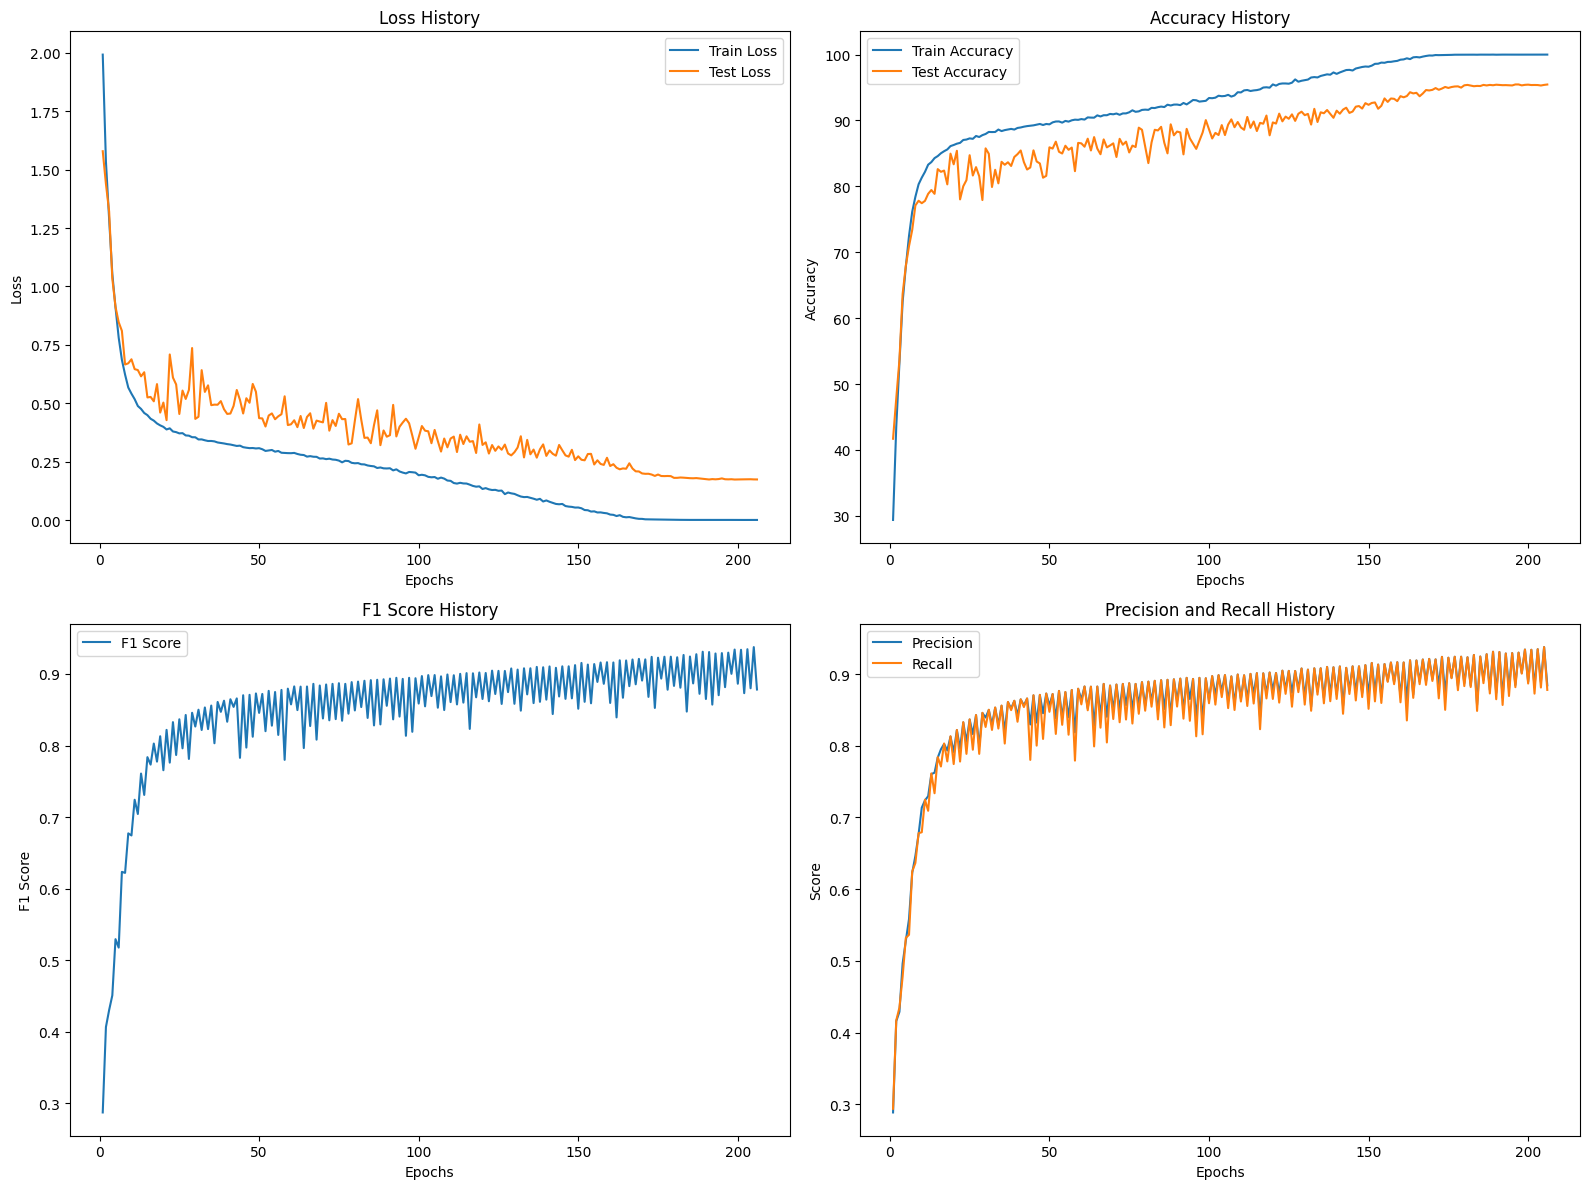

In [18]:
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming history has been saved during training
history_path = f'{project_dir}/history.pth'

# Load history
history = torch.load(history_path)

def plot_history():
    # Determine the minimum length of the history lists to avoid dimension mismatch
    min_length = min(len(history['train_loss']), len(history['test_loss']),
                     len(history['train_acc']), len(history['test_acc']),
                     len(history['f1']), len(history['precision']), len(history['recall']))

    epochs = range(1, min_length + 1)

    plt.figure(figsize=(16, 12))

    # Plot Loss History
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history['train_loss'][:min_length], label='Train Loss')
    plt.plot(epochs, history['test_loss'][:min_length], label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.legend()

    # Plot Accuracy History
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history['train_acc'][:min_length], label='Train Accuracy')
    plt.plot(epochs, history['test_acc'][:min_length], label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy History')
    plt.legend()

    # Plot F1 Score History
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history['f1'][:min_length], label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score History')
    plt.legend()

    # Plot Precision and Recall History
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history['precision'][:min_length], label='Precision')
    plt.plot(epochs, history['recall'][:min_length], label='Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Precision and Recall History')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{project_dir}/training_plots.png')
    plt.show()

# Call the function to plot the training and evaluation metrics
plot_history()


<ipython-input-14-8b8f6832209c>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'{project_dir}/checkpoint.pth')


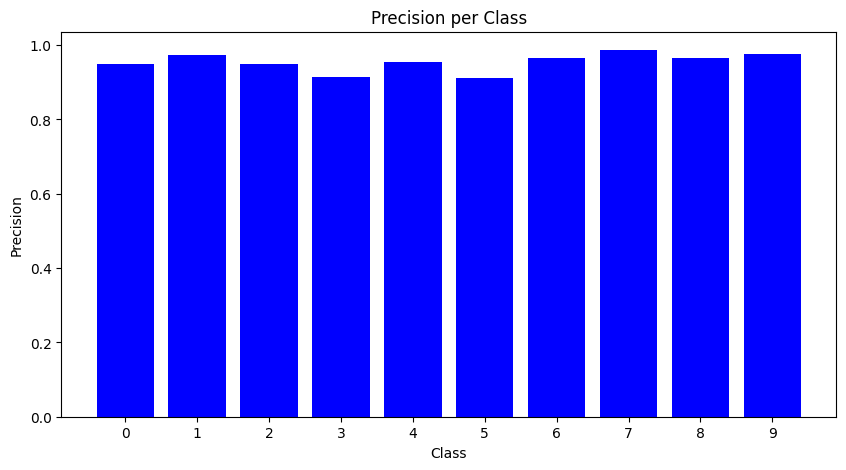

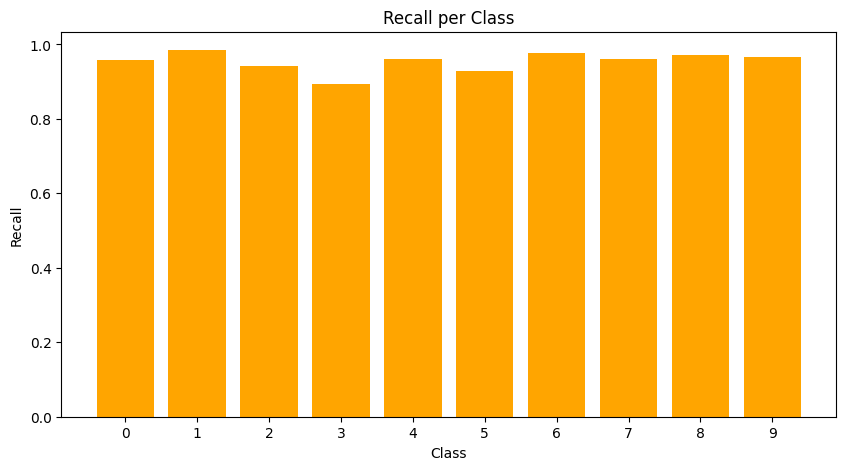

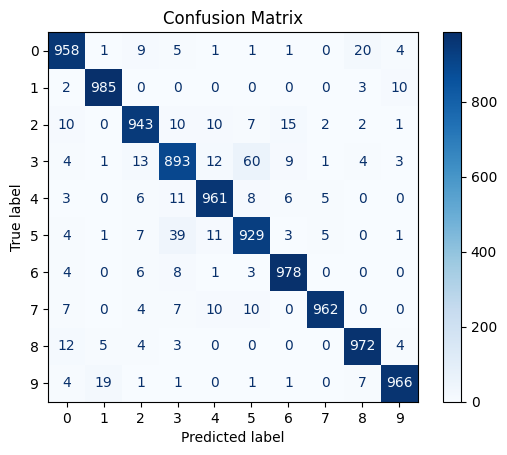

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime

# Load best model
checkpoint = torch.load(f'{project_dir}/checkpoint.pth')
net.load_state_dict(checkpoint['net'])

# Function to compute precision, recall, and confusion matrix
def compute_metrics(loader):
    net.eval()
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            _, predicted = outputs.max(1)
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    precision, recall, _, _ = precision_recall_fscore_support(all_targets, all_predictions, average=None)
    cm = confusion_matrix(all_targets, all_predictions)
    return precision, recall, cm

# Compute precision, recall, and confusion matrix for test data
precision, recall, cm = compute_metrics(testloader)

# Generate a timestamp to uniquely name the plots
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Plot precision matrix
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(precision)), precision, color='blue')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision per Class')
plt.xticks(np.arange(len(precision)), np.arange(len(precision)))
plt.savefig(f'{project_dir}/precision_matrix_{timestamp}.png')
plt.show()

# Plot recall matrix
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(recall)), recall, color='orange')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Recall per Class')
plt.xticks(np.arange(len(recall)), np.arange(len(recall)))
plt.savefig(f'{project_dir}/recall_matrix_{timestamp}.png')
plt.show()

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig(f'{project_dir}/confusion_matrix_{timestamp}.png')
plt.show()
